# Necassary Imports

In [1]:
# Imports
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
#import inflect
#from num2words import num2words
from nltk.corpus import stopwords
from collections import Counter

import sklearn

from gensim.models import Word2Vec

from sklearn.model_selection import ParameterSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV

from nltk.stem import WordNetLemmatizer
import nltk 


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\netha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Necassary preprocessing steps

In [2]:
# Import data
df = pd.read_csv('us_equities_news_dataset.csv')

In [3]:
# Filter out Nvidia articles
nvidia_df = df[df['title'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['content'].str.contains('NVIDIA|NVDA', case=False, na=False) |
               df['ticker'].str.contains('NVIDIA|NVDA', case=False, na=False)]

In [4]:
print(len(nvidia_df))

3464


In [5]:
#Pre processing steps
def preprocess_text_iteration1(text):
    text = text.strip()
    # Replace URLs with an empty string
    re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    words = word_tokenize(text.lower())
    #check if the word is alpha numeric
    alpha_words = [word for word in words if word.isalpha()]
    #remove numbers
    numbers_words = [word for word in alpha_words if not word.isdigit()]
    #stop words removal
    stop_words = set(stopwords.words('english'))
    stop_words_removed = [word for word in numbers_words if not word in stop_words]
    #add lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in stop_words_removed]

    return lemmatized_words

# apply preprocessing

# include title in "content"
nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)

## Remove words that appear too frequently or too infrequently
# Count the frequency of each word
all_words = [word for content in nvidia_df['content'] for word in content]
word_freq = Counter(all_words)

# Define thresholds (play around with these)
min_freq = 5
max_freq = 0.7 * len(nvidia_df)

# Filter words based on frequency
filtered_words = {word for word, freq in word_freq.items() if min_freq <= freq <= max_freq}

# Update the DataFrame with filtered words
def filter_content(content):
    return [word for word in content if word in filtered_words]


nvidia_df['content'] = nvidia_df['content'].apply(filter_content)


C:\Users\netha\AppData\Local\Temp\ipykernel_5408\2458803087.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['title'] + ' ' + nvidia_df['content']
C:\Users\netha\AppData\Local\Temp\ipykernel_5408\2458803087.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['content'] = nvidia_df['content'].apply(preprocess_text_iteration1)
C:\Users\netha\AppData\Local\Temp\ipykernel_5408\2458803087.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [6]:
#create a document term matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(nvidia_df['content'].apply(lambda x: ' '.join(x)))
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## FLSA-W

In [7]:
# FuzzyTM FLSA-W
from FuzzyTM import FLSA_W

# Coherence and Diversity



In [8]:


# create a FLSA-W model (based on the previous iteration, we can conclude that 5 topics is best)
# We continue with 5 topics since we notice the coherence is highest, and the diversity is also good (but not the highest)
flsaW = FLSA_W(
input_file = nvidia_df['content'].to_list(),
num_topics=5,
num_words=10,
)
flsaW.get_vocabulary_size()
pwgt, ptgd = flsaW.get_matrices() # THIS TRAINS THE MODEL
print(flsaW.show_topics())


[(0, '0.0182*"generation" + 0.0161*"margin" + 0.0156*"expect" + 0.0144*"executive" + 0.0143*"gross" + 0.0142*"know" + 0.0136*"half" + 0.0135*"think" + 0.013*"chief" + 0.013*"server"'), (1, '0.0004*"premarket" + 0.0003*"unveils" + 0.0003*"smh" + 0.0003*"uncover" + 0.0003*"conclusively" + 0.0003*"esp" + 0.0003*"avoided" + 0.0003*"soxx" + 0.0003*"strategiesit" + 0.0003*"delve"'), (2, '0.0033*"compared" + 0.0033*"adoption" + 0.0032*"gaming" + 0.0031*"basis" + 0.0031*"computing" + 0.0029*"ago" + 0.0028*"segment" + 0.0028*"believe" + 0.0027*"significant" + 0.0027*"fourth"'), (3, '0.0017*"corporation" + 0.0016*"investing" + 0.0015*"corp" + 0.0015*"gained" + 0.0015*"com" + 0.0014*"surged" + 0.0014*"released" + 0.0014*"point" + 0.0013*"added" + 0.0013*"boost"'), (4, '0.0006*"inbox" + 0.0005*"previously" + 0.0005*"phlx" + 0.0005*"amat" + 0.0005*"ratio" + 0.0005*"contract" + 0.0005*"ltd" + 0.0005*"advancing" + 0.0005*"bac" + 0.0005*"gmt"')]


## LDA

c:\Users\netha\OneDrive - TU Eindhoven\School\2024-2025\NLP\venv\Lib\site-packages\sklearn\model_selection\_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\netha\OneDrive - TU Eindhoven\School\2024-2025\NLP\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 969, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
c:\Users\netha\OneDrive - TU Eindhoven\School\2024-2025\NLP\venv\Lib\site-packages\sklearn\model_selection\_search.py:1102: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[['trading', 'point', 'percent', 'since', 'close', 'would', 'fell', 'future', 'back', 'rose'], ['cloud', 'fiscal', 'based', 'gaming', 'performance', 'ai', 'driving', 'demand', 'device', 'current']]
Topic 0: trading point percent since close would fell future back rose
Topic 1: cloud fiscal based gaming performance ai driving demand device current
[0 0 0 ... 1 1 1]


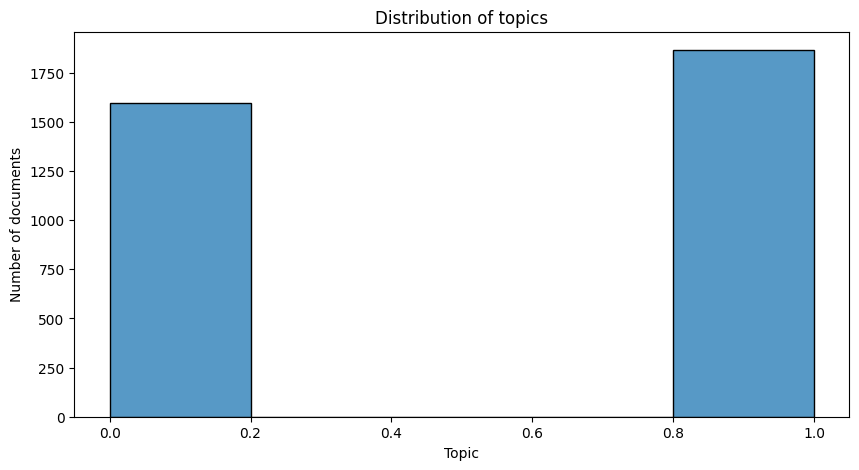

In [9]:
# train LDAModel
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def get_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in model.components_:
        topic_words = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append(topic_words)
    return topics

# Define a custom scoring function
def custom_scorer(estimator, X):
    topics = get_topics(estimator, vectorizer, 10)
    coherence = flsaW.get_coherence_score(nvidia_df['content'].to_list(), topics)
    diversity = flsaW.get_diversity_score(topics)
    return coherence * diversity

# Define the parameter grid
param_grid = {
    'n_components': [2,4,5,6,7],
    'learning_decay': [0.5, 0.7, 0.9]
}

# Initialize the LDA model
lda = LatentDirichletAllocation(random_state=0)

# Perform grid search with custom scoring
grid_search = GridSearchCV(lda, param_grid, cv=5, scoring=make_scorer(custom_scorer))
grid_search.fit(X)

# Get the best model
best_lda = grid_search.best_estimator_

# Fit the best model
best_lda.fit(X)



topics = get_topics(best_lda, vectorizer, 10)
print(topics)
for i, topic in enumerate(topics):
    print('Topic {}: {}'.format(i, ' '.join(topic)))


# get topic distribution for each document
topic_dist = best_lda.transform(X).argmax(axis=1)
print(topic_dist)

#plot the distribution of topics
plt.figure(figsize=(10, 5))
sns.histplot(topic_dist, bins=5)
plt.xlabel('Topic')
plt.ylabel('Number of documents')
plt.title('Distribution of topics')
plt.show()



In [10]:
# create a cluster plot for the topics

#if we have more time we look this because it is a cool plot (we don't fully understand it because copilot made it)

# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=0)
# tsne_embedding = tsne.fit_transform(topic_dist)
# plt.figure(figsize=(10, 5))
# sns.scatterplot(x=tsne_embedding[:, 0], y=tsne_embedding[:, 1], hue=topic_dist.argmax(axis=1), palette='tab10')
# plt.xlabel('t-SNE component 1')
# plt.ylabel('t-SNE component 2')
# plt.title('t-SNE plot of topics')
# plt.show()

## Compute Diversity, Coherence, Interpretability for FLSA-W and LDA

In [11]:
for topic in flsaW.show_topics(representation='words'):
    print(topic)


print(flsaW.get_coherence_score()) # ask if this has to be high
print(flsaW.get_diversity_score()) # ask if this has to be high
print(flsaW.get_interpretability_score()) # ask if this has to be high




['generation', 'margin', 'expect', 'executive', 'gross', 'know', 'half', 'think', 'chief', 'server']
['premarket', 'unveils', 'smh', 'uncover', 'conclusively', 'esp', 'avoided', 'soxx', 'strategiesit', 'delve']
['compared', 'adoption', 'gaming', 'basis', 'computing', 'ago', 'segment', 'believe', 'significant', 'fourth']
['corporation', 'investing', 'corp', 'gained', 'com', 'surged', 'released', 'point', 'added', 'boost']
['inbox', 'previously', 'phlx', 'amat', 'ratio', 'contract', 'ltd', 'advancing', 'bac', 'gmt']
0.44759281214378693
1.0
0.44759281214378693


In [12]:
#coherence for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
coherence_lda = flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
topics)

print(coherence_lda)

0.5316294972649815


In [13]:
#diversity for lda (we make sure tha the content is the same as the content used to train FLSA-W and LDA)
diversity_lda = flsaW.get_diversity_score(topics)
print(diversity_lda)

1.0


In [14]:
#lda interpretability
interpretability_lda = diversity_lda * coherence_lda
print(interpretability_lda)

0.5316294972649815


## Elbow plots (FLSA-W and LDA)

1
2
3
4
5
6
7
8
9
10


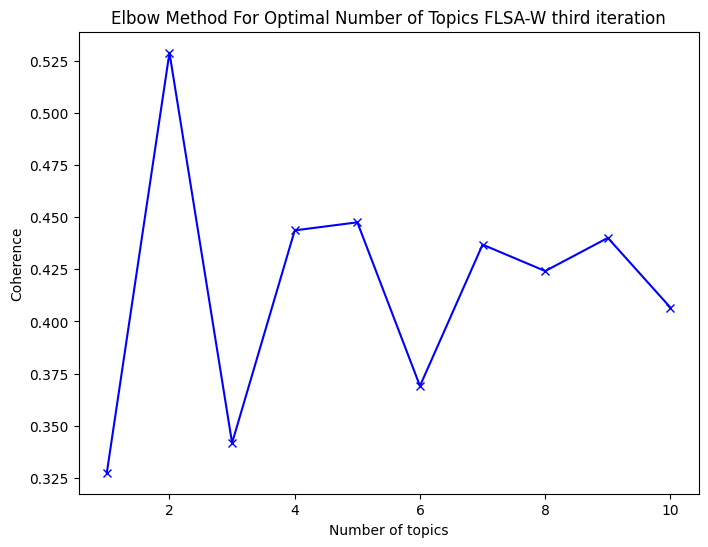

In [15]:
#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    #train model
    print(n_topics)
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get coherence
    coherence = flsaW_elbow.get_coherence_score()
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W third iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


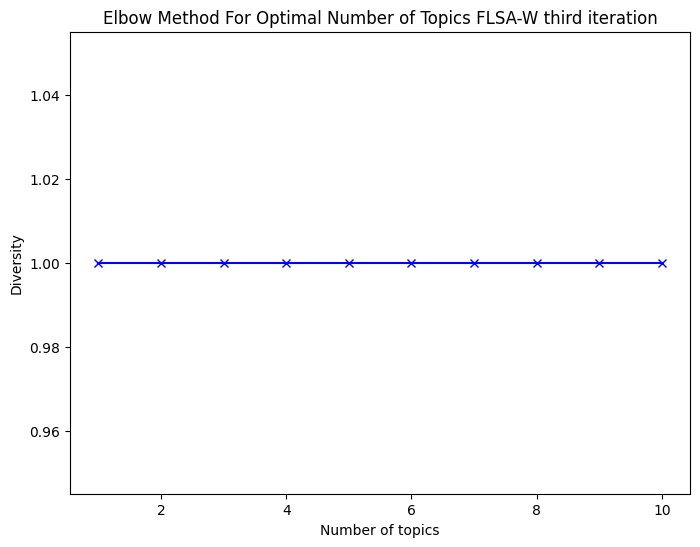

In [16]:
#elbow plot for diversity

#elbow plot for FLSA-W
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    flsaW_elbow = FLSA_W(
    input_file = nvidia_df['content'].to_list(),
    num_topics=n_topics,
    num_words=10,
    )
    flsaW_elbow.get_vocabulary_size()
    pwgt, ptgd = flsaW_elbow.get_matrices() # THIS TRAINS THE MODEL
    #get diversity
    diversity = flsaW_elbow.get_diversity_score()
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W third iteration') 
plt.show()


1
2
3
4
5
6
7
8
9
10


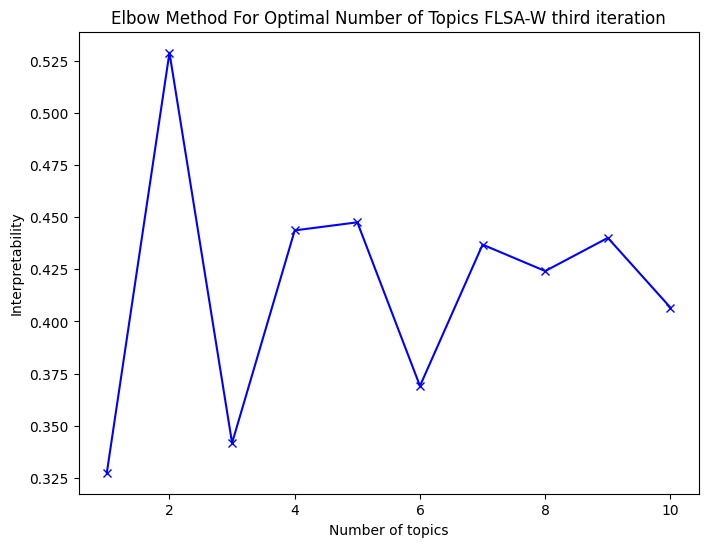

In [17]:
#elbow plot for interpretability
range_n_topics = range(1, 11)
#elbow plot for FLSA-W
interpretabilities = []
for i in range_n_topics:
    print(i)
    interpretability =  coherences[i-1]*diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics FLSA-W third iteration')
plt.show()

## LDA

1
2
3
4
5
6
7
8
9
10


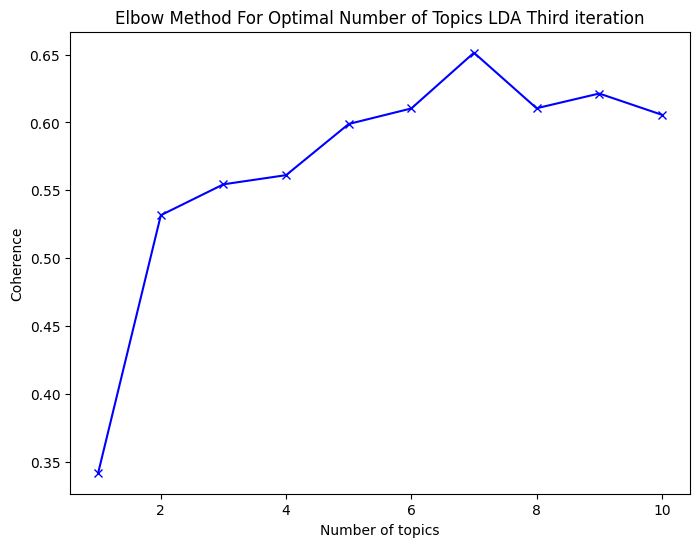

In [18]:
#elbow plot for coherence

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get coherence
    topics = get_topics(lda, vectorizer, 10)

    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    topics)
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics LDA Third iteration')
plt.show()


1
2
3
4
5
6
7
8
9
10


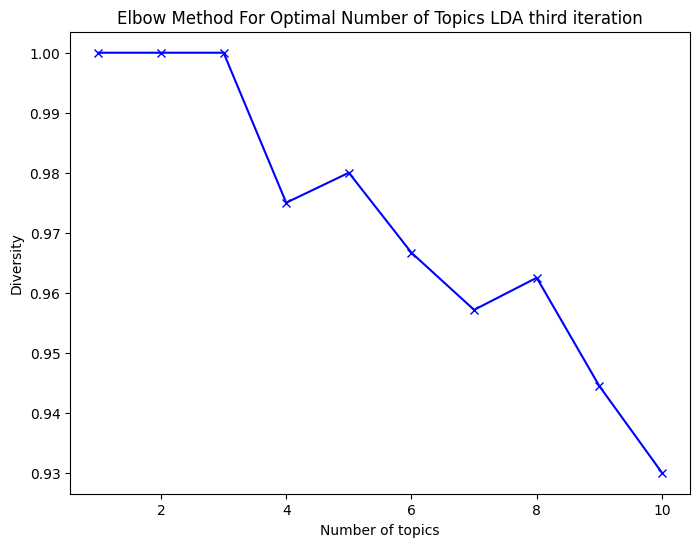

In [19]:
#elbow plot for diversity

#elbow plot for LDA
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #train model
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
    lda.fit(X)
    #get diversity
    topics = get_topics(lda, vectorizer, 10)

    diversity = flsaW.get_diversity_score(
    
    topics)
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics LDA third iteration')
plt.show()

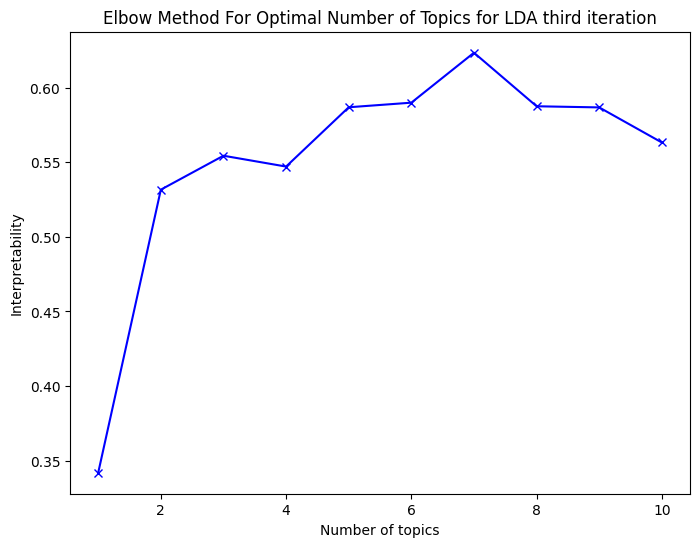

In [20]:
#elbow plot for interpretability

#elbow plot for LDA
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics for LDA third iteration')
plt.show()

They remain stable. It would be interesting to write a discussion. (there is little variation why?)

## Bert Topic

In [21]:
from bertopic import BERTopic
from umap import UMAP
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=0)
docs = [' '.join(doc) for doc in nvidia_df['content']]
# Create the model (uses DistilBERT by default)
bert_topic = BERTopic(umap_model=umap_model)
# Train the model and transform your data into topics
topic_assigned_to_doc, _ = bert_topic.fit_transform(docs)
topic_matrix = bert_topic.get_topic_info()
bert_topic.get_topics()



c:\Users\netha\OneDrive - TU Eindhoven\School\2024-2025\NLP\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{-1: [('current', 0.005334578209062539),
  ('past', 0.0050178508764872915),
  ('device', 0.0049822092864292376),
  ('percent', 0.004902261905038608),
  ('two', 0.004640836268595469),
  ('long', 0.004618476566748331),
  ('average', 0.004610937976758574),
  ('amazon', 0.004601230308829278),
  ('make', 0.004589077030305031),
  ('future', 0.004575743861321235)],
 0: [('cent', 0.01702298772843191),
  ('gaap', 0.014282760202044392),
  ('cash', 0.013988620584239176),
  ('surprise', 0.013867933765436059),
  ('range', 0.013108990366615178),
  ('margin', 0.01294709457696292),
  ('increased', 0.012770012929214003),
  ('esp', 0.012620399148335185),
  ('reported', 0.012023887013410513),
  ('positive', 0.01189631209873973)],
 1: [('etf', 0.06989779765986241),
  ('fund', 0.05083444020372454),
  ('exposure', 0.021001043607097432),
  ('fee', 0.016753919047421927),
  ('read', 0.016744934930234327),
  ('asset', 0.015556945463289746),
  ('holding', 0.015321338647320366),
  ('charge', 0.014125815692802865)

In [22]:
print(topic_matrix)

    Topic  Count                                Name  \
0      -1   1063      -1_current_past_device_percent   
1       0    196           0_cent_gaap_cash_surprise   
2       1    117             1_etf_fund_exposure_fee   
3       2    112          2_driving_car_vehicle_self   
4       3     95   3_resistance_around_towards_break   
..    ...    ...                                 ...   
69     68     13         68_netapp_cloud_flash_array   
70     69     13        69_greece_bank_euro_european   
71     70     13  70_western_digital_sandisk_storage   
72     71     12          71_traded_gmt_seven_lowest   
73     72     10     72_nike_apparel_lilly_nordstrom   

                                       Representation  \
0   [current, past, device, percent, two, long, av...   
1   [cent, gaap, cash, surprise, range, margin, in...   
2   [etf, fund, exposure, fee, read, asset, holdin...   
3   [driving, car, vehicle, self, autonomous, syst...   
4   [resistance, around, towards, break, r

In [23]:
bert_topic.visualize_heatmap(n_clusters=15)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'coloraxis': 'coloraxis',
              'hovertemplate': 'x: %{x}<br>y: %{y}<br>Similarity Score: %{z}<extra></extra>',
              'name': '0',
              'type': 'heatmap',
              'x': [0_cent_gaap_cash, 1_etf_fund_exposure, 10_micron_dram_mu,
                    26_remarkably_obligation_ye..., 33_netflix_streaming_original,
                    50_instrument_texas_ti, 57_tripadvisor_hotel_pricel...,
                    62_applied_material_amat, 66_broadcom_avgo_amgen,
                    2_driving_car_vehicle, 39_tesla_musk_driving,
                    56_baidu_apollo_driving, 3_resistance_around_towards,
                    7_tracey_podcast_value, 11_trading_call_vix,
                    17_portfolio_today_editor, 20_cap_short_small,
                    42_illumina_missed_biotech, 4_ai_learning_machine,
                    27_huawei_chinese_hikvision, 28_mellanox_ethernet_switch,
                    30_iphone_india_ipad, 44_microsoft_google_azure,
                    45_tsmc_chang_samsung, 46_qualcomm_nxp_broadcom,
                    5_target_rating_reiterates, 23_corporation_swing_therap...,
                    31_premarket_et_gmt, 72_nike_apparel_lilly,
                    6_radeon_graphic_gpu, 35_processor_dell_supercomp...,
                    53_game_stadium_gaming, 61_cadence_design_verificat...,
                    8_gaming_gpus_gpu, 18_projected_climb_roughly,
                    29_datacenter_graphic_gaming, 51_demand_gaming_center,
                    9_close_performer_settle, 12_walmart_retailer_wmt,
                    13_tariff_trump_chinese, 14_dow_trump_boeing,
                    15_percent_yield_dollar, 21_oil_crude_energy,
                    22_point_percent_wall, 34_coronavirus_virus_outbreak,
                    38_future_et_point, 55_dow_closed_jones, 58_inflation_fed_bank,
                    64_forecast_versus_production, 16_facebook_user_ad,
                    19_mining_cryptocurrency_cr..., 32_bitcoin_currency_cryptoc...,
                    59_softbank_vision_fund, 63_game_esports_activision,
                    24_traded_gmt_seven, 25_traded_gmt_seven, 36_traded_gmt_seven,
                    40_traded_gmt_seven, 48_traded_gmt_seven, 54_traded_gmt_seven,
                    71_traded_gmt_seven, 37_qualcomm_patent_commission,
                    41_scenario_oil_pivot, 43_italy_rallied_soared,
                    47_brexit_bank_vote, 69_greece_bank_euro, 49_surprise_beat_esp,
                    60_ratio_peg_value, 65_period_member_eps, 52_eps_beat_com,
                    67_storage_pure_pstg, 68_netapp_cloud_flash,
                    70_western_digital_sandisk],
              'xaxis': 'x',
              'y': [0_cent_gaap_cash, 1_etf_fund_exposure, 10_micron_dram_mu,
                    26_remarkably_obligation_ye..., 33_netflix_streaming_original,
                    50_instrument_texas_ti, 57_tripadvisor_hotel_pricel...,
                    62_applied_material_amat, 66_broadcom_avgo_amgen,
                    2_driving_car_vehicle, 39_tesla_musk_driving,
                    56_baidu_apollo_driving, 3_resistance_around_towards,
                    7_tracey_podcast_value, 11_trading_call_vix,
                    17_portfolio_today_editor, 20_cap_short_small,
                    42_illumina_missed_biotech, 4_ai_learning_machine,
                    27_huawei_chinese_hikvision, 28_mellanox_ethernet_switch,
                    30_iphone_india_ipad, 44_microsoft_google_azure,
                    45_tsmc_chang_samsung, 46_qualcomm_nxp_broadcom,
                    5_target_rating_reiterates, 23_corporation_swing_therap...,
                    31_premarket_et_gmt, 72_nike_apparel_lilly,
                    6_radeon_graphic_gpu, 35_processor_dell_supercomp...,
                    53_game_stadium_gaming, 61_cadence_design_verificat...,
                    8_gaming_gpus_gpu, 18_projected_climb_roughly,
                    29_datacenter_graphic_gaming, 51_demand_gaming_

In [24]:
topic_matrix.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1063,-1_current_past_device_percent,"[current, past, device, percent, two, long, av...",[idea feature highlight lam analog device imme...
1,0,196,0_cent_gaap_cash_surprise,"[cent, gaap, cash, surprise, range, margin, in...",[fireeye feye soar ever positive fireeye feye ...
2,1,117,1_etf_fund_exposure_fee,"[etf, fund, exposure, fee, read, asset, holdin...",[etf focus closing bell yesterday reported str...
3,2,112,2_driving_car_vehicle_self,"[driving, car, vehicle, self, autonomous, syst...",[challenge self driving car space corporation ...
4,3,95,3_resistance_around_towards_break,"[resistance, around, towards, break, roku, sup...",[prediction g bullish spy going try pick left ...
5,4,72,4_ai_learning_machine_intelligence,"[ai, learning, machine, intelligence, ml, arti...",[fast growing ai win big artificial intelligen...
6,5,71,5_target_rating_reiterates_rbc,"[target, rating, reiterates, rbc, raise, previ...",[jefferies increase target jefferies raise tar...
7,6,68,6_radeon_graphic_gpu_card,"[radeon, graphic, gpu, card, gaming, processor...",[boost gaming experience radeon graphic card a...
8,7,63,7_tracey_podcast_value_episode,"[tracey, podcast, value, episode, ryniec, stra...",[value highlight micron applied material lam i...
9,8,61,8_gaming_gpus_gpu_fiscal,"[gaming, gpus, gpu, fiscal, gaap, non, geforce...",[since gone since added frame outperforming re...


In [25]:
# print the name of the topic matrix and the representative docs using for loop
for i in range(0, 11):
    print(topic_matrix['Name'][i])
    print(topic_matrix['Representative_Docs'][i])
    print('')

-1_current_past_device_percent
['idea feature highlight lam analog device immediate release chicago il today idea feature highlight feature lam analog device still chasing stayed long big order unfortunately follower listened crowd wall street bank neutral bearish valuation concern recommended taking profit near another solid launched toward quickly became reviewing show outlook next immediately knew made mistake even though none bank target near ready admit besides suck pay hope would slow bit give chance get back sure pay eps multiple maker hot selling ai called gpus used everything gaming console ibm ibm watson driverless wheeler europe latest cloud computing customer security application brand ai hardware going stay dominant demand several certainly hurt planned hybrid conference morning revealed powerful innovation specialty processor learn gpu made march select bank agreed saw light early goldman sachs g raised target rbc quickly raised pt bank america bac select group bull raisi

In [26]:
#create a list of the first 10 representative docs
rep_docs = topic_matrix['Representation'][1:10].to_list()
print(rep_docs)




[['cent', 'gaap', 'cash', 'surprise', 'range', 'margin', 'increased', 'esp', 'reported', 'positive'], ['etf', 'fund', 'exposure', 'fee', 'read', 'asset', 'holding', 'charge', 'score', 'basket'], ['driving', 'car', 'vehicle', 'self', 'autonomous', 'system', 'automotive', 'uber', 'automaker', 'mobileye'], ['resistance', 'around', 'towards', 'break', 'roku', 'support', 'level', 'rise', 'gap', 'jd'], ['ai', 'learning', 'machine', 'intelligence', 'ml', 'artificial', 'cloud', 'deep', 'inference', 'ibm'], ['target', 'rating', 'reiterates', 'rbc', 'raise', 'previously', 'upside', 'read', 'center', 'say'], ['radeon', 'graphic', 'gpu', 'card', 'gaming', 'processor', 'ryzen', 'rx', 'rtx', 'ray'], ['tracey', 'podcast', 'value', 'episode', 'ryniec', 'strategist', 'book', 'investing', 'joined', 'discus'], ['gaming', 'gpus', 'gpu', 'fiscal', 'gaap', 'non', 'geforce', 'ai', 'sequentially', 'platform']]


In [27]:
#bert coherence --> just say we tried, in the end it doesn't matter I tried hard and got so far 
print(
flsaW.get_coherence_score(
nvidia_df['content'].to_list(),
rep_docs[0:4])
)



0.7736619429662293


In [28]:
#bert diversity
print(flsaW.get_diversity_score(rep_docs[0:4]))

1.0


1
2
3
4
5
6
7
8
9
10


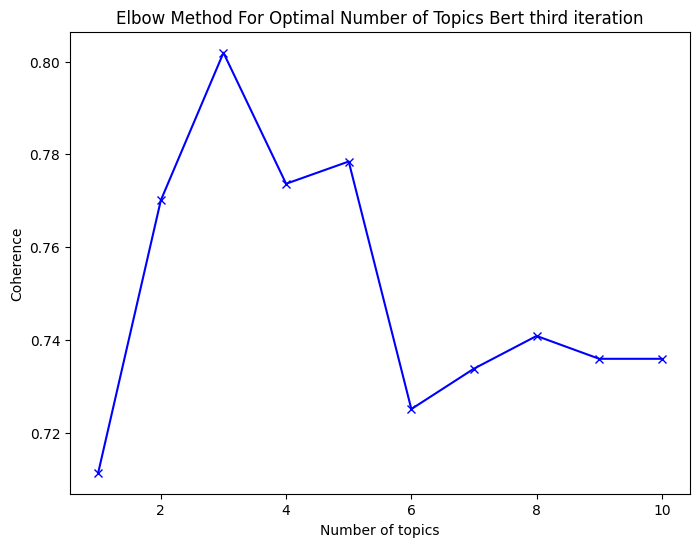

In [29]:
#elbow plot for coherence

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of coherence values
coherences = []
for n_topics in range_n_topics:
    print(n_topics)
    #get coherence
    coherence = flsaW.get_coherence_score(
    nvidia_df['content'].to_list(),
    rep_docs[0:n_topics])
    coherences.append(coherence)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, coherences, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Coherence')
plt.title('Elbow Method For Optimal Number of Topics Bert third iteration')
plt.show()


topic

1
2
3
4
5
6
7
8
9
10


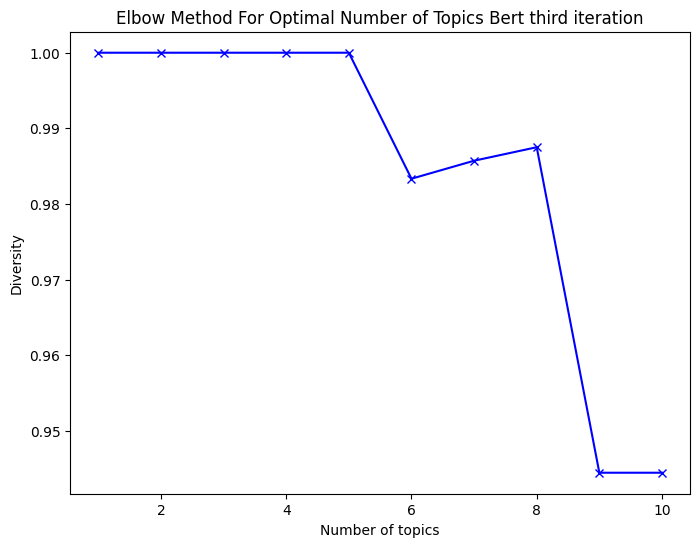

In [30]:
#elbow plot for diversity

#elbow plot for Bert
range_n_topics = range(1, 11)

# Create a list of diversity values
diversities = []
for n_topics in range_n_topics:
    print(n_topics)
    #get diversity
    diversity = flsaW.get_diversity_score(rep_docs[0:n_topics])
    diversities.append(diversity)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, diversities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Diversity')
plt.title('Elbow Method For Optimal Number of Topics Bert third iteration')
plt.show()

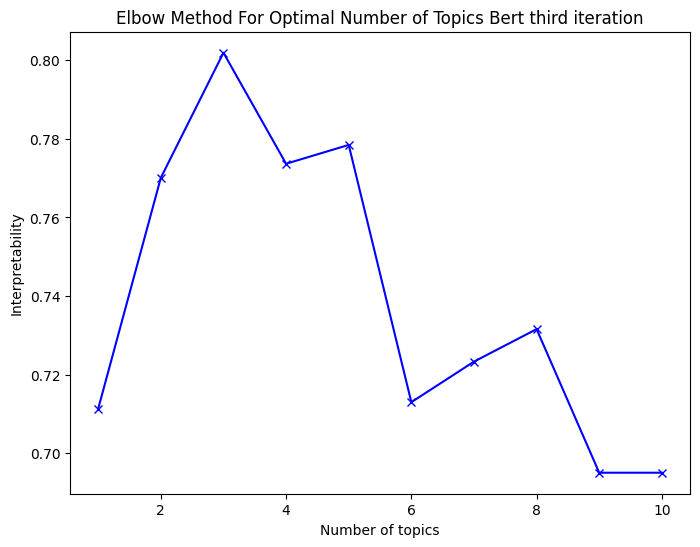

In [31]:
#elbow plot for interpretability

#elbow plot for Bert
interpretabilities = []
for i in range_n_topics:
    interpretability = coherences[i-1] * diversities[i-1]
    interpretabilities.append(interpretability)

# Plot the elbow plot
plt.figure(figsize=(8, 6))
plt.plot(range_n_topics, interpretabilities, 'bx-')
plt.xlabel('Number of topics')
plt.ylabel('Interpretability')
plt.title('Elbow Method For Optimal Number of Topics Bert third iteration')
plt.show()